In [65]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import numpy.random as nprnd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
import time

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.sensing import sensor_utils

# Autoreload jupyter.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Load in fault table
fault_table_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\Precip_Noise\diameter_17.csv"
fault_table = pd.read_csv(fault_table_fp)

In [100]:
def find_storms(P, thresh):
    # Integer boolean array where P > thresh.
    exceed = P > thresh
    exceed = exceed.astype(int)
    
    # Difference between boolean exceedances.
    exceed_diff = np.diff(exceed)
    
    # Storms start where exceed is equal to 1 (i.e., crosses threshold).
    storm_start_idx = np.where(exceed_diff == 1)[0]
    
    # Storm end index is the storm start index plus the last index.
    storm_end_idx = np.append(storm_start_idx[1:], len(P)-1)
    
    return storm_start_idx, storm_end_idx

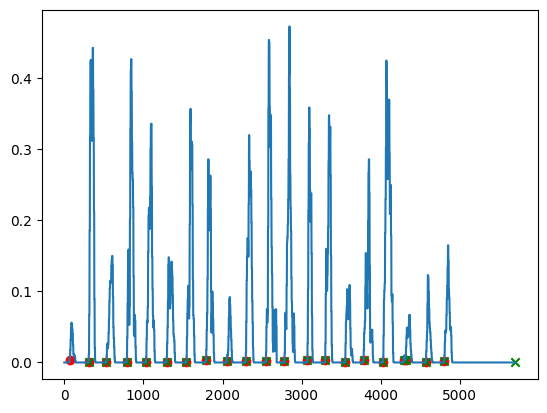

In [101]:
# Fault values
fault_values = np.unique(fault_table['fault_value'])

# Specific fault value.
fault_value = fault_values[10]

# Datetime
t = fault_table.loc[fault_table['fault_value'] == fault_value, 'datetime']

# Precipitation
P = fault_table.loc[fault_table['fault_value'] == fault_value, 'prcp'].to_numpy()

# Storm start and end indices.
P_thresh = 0.005
storm_start_idx, storm_end_idx = find_storms(P, P_thresh)

fig, ax = plt.subplots()
ax.plot(P)
ax.scatter(storm_start_idx, P[storm_start_idx], c='r')
ax.scatter(storm_end_idx, P[storm_end_idx], c='g', marker='x')

In [102]:
# Flood columns.
node_flood_cols = [i for i in fault_table.columns if "Flood_node" in i]
# node_flood_cols = ['Flood_node_7']

In [103]:
# Total node flooding for each peak

# Precipitation metric. Peak, cumu, density.
prcp_metric_flag = 'cumu'

fault_node_flooding = np.zeros((len(fault_values), len(storm_start_idx)))
fault_node_flooding = {
    'fault_value': [],
    'prcp_metric': [],
    'flooding': []
}
for i, fault_value in enumerate(fault_values):
    # Extract node flooding column(s).
    node_flood = fault_table.loc[fault_table['fault_value'] == fault_value, node_flood_cols].to_numpy()
    node_flood[node_flood < 0] = 0
    
    # Loop through peaks and compute cumulative flooding.
    for j in range(len(storm_start_idx)):
        # Node flooding for a given peak.
        node_peak_flood = node_flood[storm_start_idx[j]:storm_end_idx[j], :]
        if node_peak_flood.shape[1] > 1:
            cumu_node_flood = np.sum(np.trapz(node_peak_flood, axis=0, dx=5*60))
        else:
            cumu_node_flood = np.trapz(node_peak_flood, axis=0, dx=5*60)
            
        # Peak precipitation.
        if prcp_metric_flag == 'peak':
            prcp_metric = np.max(P[storm_start_idx[j]:storm_end_idx[j]])
        elif prcp_metric_flag == 'cumu':
            prcp_metric = np.sum(P[storm_start_idx[j]:storm_end_idx[j]])
        
        # Populate fault node flooding dictionary.
        fault_node_flooding['fault_value'].append(fault_value)
        fault_node_flooding['prcp_metric'].append(prcp_metric)
        fault_node_flooding['flooding'].append(cumu_node_flood)
                
# Make a data frame from fault_node_flooding.
fault_node_flood_df = pd.DataFrame(fault_node_flooding)
fault_node_flood_array = fault_node_flood_df.to_numpy()

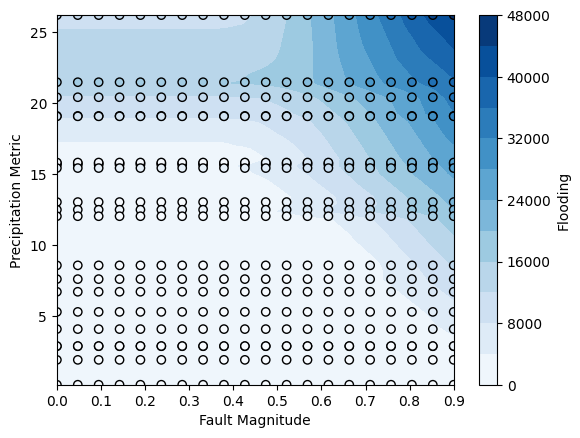

In [104]:

def grid(x, y, z, resX=50, resY=50):
    "Convert 3 column data to matplotlib grid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    grid_x, grid_y = np.meshgrid(xi, yi)
    
    Z = griddata(np.column_stack((x, y)), z, (grid_x, grid_y))
    return grid_x, grid_y, Z

X, Y, Z = grid(fault_node_flood_array[:,0], fault_node_flood_array[:,1], fault_node_flood_array[:,2])

fig, ax = plt.subplots()
cf = ax.contourf(X, Y, Z, levels=12, cmap='Blues')
ax.scatter(fault_node_flood_array[:,0], fault_node_flood_array[:,1], c=fault_node_flood_array[:,2], 
          edgecolor='k', cmap='Blues')
ax.set_xlabel('Fault Magnitude')
ax.set_ylabel('Precipitation Metric')
fig.colorbar(cf, label='Flooding')

### Modeled node flooding under healthy system assumption.

In [105]:
# Load in healthy data.
healthy_table_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\Precip_Noise\healthy_Pmeas.csv"
healthy_table = pd.read_csv(healthy_table_fp)

(21, 2)


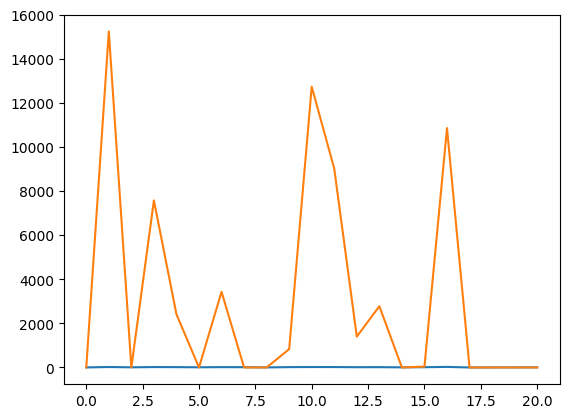

In [109]:
# Modeled precip.
P_healthy = healthy_table['prcp'].to_numpy()

# Storm start and end indices.
P_thresh = 0.005
H_storm_start_idx, H_storm_end_idx = find_storms(P_healthy, P_thresh)

# Precipitation metric. Peak, cumu, density.
prcp_metric_flag = 'cumu'

healthy_node_flooding = {
    'prcp_metric': [],
    'flooding': []
}

node_flood = healthy_table.loc[:, node_flood_cols].to_numpy()
node_flood[node_flood < 0] = 0

# Loop through peaks and compute cumulative flooding.
for j in range(len(H_storm_start_idx)):
    # Node flooding for a given peak.
    node_peak_flood = node_flood[H_storm_start_idx[j]:H_storm_end_idx[j], :]
    if node_peak_flood.shape[1] > 1:
        cumu_node_flood = np.sum(np.trapz(node_peak_flood, axis=0, dx=5*60))
    else:
        cumu_node_flood = np.trapz(node_peak_flood, axis=0, dx=5*60)

    # Peak precipitation.
    if prcp_metric_flag == 'peak':
        prcp_metric = np.max(P_healthy[H_storm_start_idx[j]:H_storm_end_idx[j]])
    elif prcp_metric_flag == 'cumu':
        prcp_metric = np.sum(P_healthy[H_storm_start_idx[j]:H_storm_end_idx[j]])

    # Populate healthy node flooding dictionary.
    healthy_node_flooding['prcp_metric'].append(prcp_metric)
    healthy_node_flooding['flooding'].append(cumu_node_flood)
    
# Make a data frame from fault_node_flooding.
healthy_node_flood_df = pd.DataFrame(healthy_node_flooding)
healthy_node_flood_array = healthy_node_flood_df.to_numpy()
print(healthy_node_flood_array.shape)
    
fig, ax = plt.subplots()
# ax.plot(fault_node_flood_array[0,:])
ax.plot(healthy_node_flood_array)

### Random sensor placement

In [60]:
# Input file path.
inp_filepath = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system.inp"
cfg_filepath = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Link dictionary.
link_node_dict = sensor_utils.link_nodes(inp_filepath)

# Adjacency matrix.
A_matrix, node_names = sensor_utils.adjacency_matrix(link_node_dict, inp_filepath)

# Number of components upstream of each sensor. Defines the sensor density.
N_upstream = np.arange(1,10)

# Link names. 
swmm = swmm_model.SWMM(cfg_filepath)
link_names = np.array(swmm.get_component_names('CONDUITS'))

# Sensor densities.
densities = np.arange(1, len(link_names), 5)
densities = np.append(densities, len(link_names))
densities = densities[::-1]

# Number of random sensor location samples.
Nsamp = 30

# Array to store the maximum residual values.
res_max = np.zeros((len(fault_values), len(peak_idx) - 1, len(densities)))
res_std = np.zeros((len(fault_values), len(peak_idx) - 1, len(densities)))
for n, N_sensor in enumerate(densities):
    print(N_sensor)
#     # Sensor_locations.
#     sensor_locations = sensor_utils.upstream_assign(link_node_dict, inp_filepath, Nups=Nups, link_sensors=True)
#     print(sensor_locations)
    
    # Array to store randomly selected sensor density arrays.
    res_sensor = np.zeros((len(fault_values), len(peak_idx) - 1, Nsamp))
    
    for r in range(Nsamp):
        # Sensor locations.
        sensor_locations = np.random.choice(link_names, N_sensor, replace=False)
        
        # Sensor columns.
        sensor_cols = [f'Velocity_link_{i}' for i in sensor_locations]

        # Healthy states.
        healthy_states = healthy_table.loc[:, sensor_cols].to_numpy()

        # Array to store residuals for a given sensor density.
        res_ar = np.zeros((len(fault_values), len(peak_idx) - 1))

        for i, fault_value in enumerate(fault_values):
            # Fault states.
            fault_states = fault_table.loc[fault_table['fault_value'] == fault_value, sensor_cols].to_numpy()

            # Loop through peaks and compute depth residuals.
            for j in range(len(storm_start_idx)):
                # Healthy states corresponding to the rainfall peak.
                healthy_peak_states = healthy_states[storm_start_idx[j]:storm_end_idx[j], :]

                # Fault states corresponding to the rainfall peak.
                fault_peak_states = fault_states[storm_start_idx[j]:storm_end_idx[j], :]

                # Compute residual.
                res_ar[i,j] = np.max(np.abs(healthy_peak_states - fault_peak_states))
                
        res_sensor[:,:,r] = res_ar

    # Add residual array to full array.
    res_max[:,:,n] = np.min(res_sensor, axis=2)
    res_std[:,:,n] = np.std(res_sensor, axis=2)

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 23:00:00
40
36
31
26
21
16
11
6
1


### Upstream link sensor placement.

In [61]:
# Link-Node dictionary.
link_node_dict = sensor_utils.link_nodes(inp_filepath, int_convert=False)

N_upstream = np.arange(1,10)
res_sensor = np.zeros((len(fault_values), len(peak_idx) - 1, len(N_upstream)))
N_algo_sensors = np.zeros(len(N_upstream))
for r, Nups in enumerate(N_upstream):
    # Sensor locations.
    sensor_locations = sensor_utils.upstream_assign_links(link_node_dict, inp_filepath, Nups=Nups, exclude_weirs=True)
    print('Number of sensors:', len(sensor_locations))
    N_algo_sensors[r] = len(sensor_locations)

    # Sensor columns.
    sensor_cols = [f'Velocity_link_{i}' for i in sensor_locations]

    # Healthy states.
    healthy_states = healthy_table.loc[:, sensor_cols].to_numpy()

    # Array to store residuals for a given sensor density.
    res_ar = np.zeros((len(fault_values), len(peak_idx) - 1))

    for i, fault_value in enumerate(fault_values):
        # Fault states.
        fault_states = fault_table.loc[fault_table['fault_value'] == fault_value, sensor_cols].to_numpy()

        # Loop through peaks and compute depth residuals.
        for j in range(len(peak_idx) - 1):
            peak_start_idx = peak_idx[j]
            peak_end_idx = peak_idx[j + 1]

            # Healthy states corresponding to the rainfall peak.
            healthy_peak_states = healthy_states[peak_start_idx:peak_end_idx, :]

            # Fault states corresponding to the rainfall peak.
            fault_peak_states = fault_states[peak_start_idx:peak_end_idx, :]

            # Compute residual.
            res_ar[i,j] = np.max(np.abs(healthy_peak_states - fault_peak_states))

    res_sensor[:,:,r] = res_ar
    

Number of sensors: 20
Number of sensors: 20
Number of sensors: 11
Number of sensors: 10
Number of sensors: 9
Number of sensors: 8
Number of sensors: 7
Number of sensors: 7
Number of sensors: 5


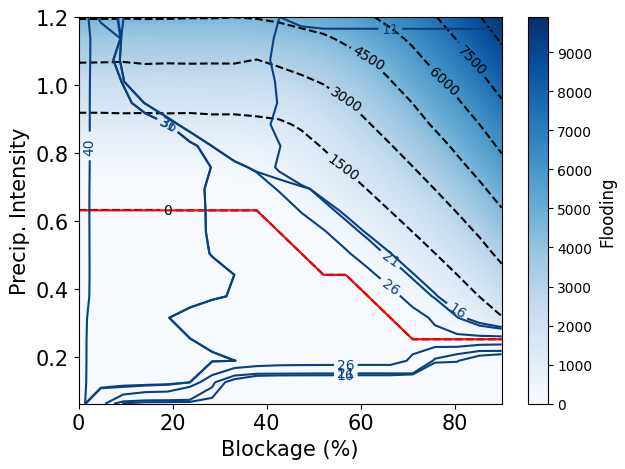

In [66]:
# Node flooding contour plot
# node_flooding_contour = np.copy(fault_node_flooding)
# node_flooding_contour[node_flooding_contour <= 0] = -500

c_levels = np.arange(0, np.max(fault_node_flooding) + (np.max(fault_node_flooding) / 50), 100)

# Residual threshold.
res_thresh = 0.3

# Fault values as a percentage of maximum fault.
plot_fault_values = fault_values / 1 * 100
# plot_fault_values = (fault_values - 0.01) / 0.01 * 100

fig, ax = plt.subplots()

contourf = ax.contourf(plot_fault_values, Ppeak, fault_node_flooding.T, levels=c_levels, cmap='Blues')
contour = ax.contour(plot_fault_values, Ppeak, fault_node_flooding.T, colors='black', linestyles='dashed')
contour_0 = ax.contour(plot_fault_values, Ppeak, fault_node_flooding.T, levels=np.array([0]), colors='red')

# Plot random sensor locations.
for n, N_sensor in enumerate(densities):
    dense_c = ax.contour(plot_fault_values, Ppeak, res_max[:,:,n].T, levels=np.array([res_thresh]), cmap='GnBu_r')
    fmt = {dense_c.levels[0]: N_sensor}
    ax.clabel(dense_c, inline=True, fontsize=10, fmt=fmt)
    
# # Plot sensor locations from algorithm.
# for n, Nsensor in enumerate(N_algo_sensors):
#     sens_c = ax.contour(plot_fault_values, Ppeak, res_sensor[:,:,n].T, levels=np.array([res_thresh]), colors='green')
#     fmt = {sens_c.levels[0]: int(Nsensor)}
#     ax.clabel(sens_c, inline=True, fontsize=10, fmt=fmt)
    
ax.clabel(contour, inline=True, fontsize=10)
cbar = fig.colorbar(contourf, ax=ax, label='Flooding')
cbar.set_label('Flooding', fontsize=12)
# ax.set_xlabel("Manning's n Increase (%)", fontsize=15)
ax.set_xlabel("Blockage (%)", fontsize=15)
ax.set_ylabel('Precip. Intensity', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
fig.tight_layout()

fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Manuscript\Figures\random_sensor_blockage_velocity.png", dpi=300)